In [50]:
import numpy as np
import cv2
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill
import os

Shape From Shading
---
### "Shape From Shading Using Linear Approximation"

Tsai & Shah, 1994, DOI:10.1016/0262-8856(94)90002-7, [URL](https://stars.library.ucf.edu/scopus1990/321/)

Shape from shading is an overall term for estimating an objects 3d-shape based on one or several 2d images.

[Tsai and Shah](https://stars.library.ucf.edu/scopus1990/321/) published their algorithm in 1995. The following code demonstrates SFS by linear approximation based on the assumption that the tilt and slant of the illumination direction are given, the camera faces the object orthogonal and the surface of the object is lambertian, meaning it scatters light upon arrival on the object into all directions rather than just one, like a mirror (or specular) object would do.

The algorithm for SFS and illumination estimation are adapted from [Shireen Elhabians work](https://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_SFS08.pdf) on different SFS methods.

# Helper Functions
For our application (coin study), we want to exclude the background of the coin, so we define a flood-fill based background removal function `create_background_mask`. Further, we estimate slant and tilt based on the gradient (Sobel) across x and y direction in `estimate_illumination`.

In [51]:
def create_background_mask(image, threshold=240):
    """
    Create mask to exclude background using flood fill
    """
    
    # Find white pixels
    background_candidates = image > threshold
    
    # Start with all pixels as foreground
    mask = np.ones(image.shape, dtype=bool)
    temp_image = background_candidates.astype(np.uint8)
    
    # Flood fill from corners to find background
    h, w = image.shape
    start_points = [(0, 0), (0, w-1), (h-1, 0), (h-1, w-1)]  # corners
    
    for start_point in start_points:
        y, x = start_point
        if temp_image[y, x] == 1:
            flooded = flood_fill(temp_image, start_point, 2, connectivity=1)
            mask[flooded == 2] = False
    
    # Clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    mask_clean = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    return mask_clean.astype(bool)

def estimate_illumination(image, mask=None):
    """
    Simple illumination parameter estimation
    """
    
    # Compute gradients
    grad_x = cv2.Sobel(image.astype(np.float64), cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image.astype(np.float64), cv2.CV_64F, 0, 1, ksize=3)
    
    # Use only foreground pixels if mask is provided
    if mask is not None:
        grad_x_masked = grad_x[mask]
        grad_y_masked = grad_y[mask]
        image_masked = image[mask]
    else:
        grad_x_masked = grad_x.flatten()
        grad_y_masked = grad_y.flatten()
        image_masked = image.flatten()
    
    # Estimate tilt from average gradient direction
    mean_grad_x = np.mean(grad_x_masked)
    mean_grad_y = np.mean(grad_y_masked)
    tilt = np.arctan2(mean_grad_y, mean_grad_x)
    
    # Estimate slant from gradient magnitude
    grad_mag = np.sqrt(grad_x_masked**2 + grad_y_masked**2)
    mean_grad_mag = np.mean(grad_mag)
    slant = np.arctan(mean_grad_mag * 2.5)  # Simple scaling factor
    slant = np.clip(slant, 0, np.pi/2)  # Keep within valid range
    
    return slant, tilt, grad_x, grad_y

def shape_from_shading(image, slant, tilt, mask=None, max_iter=200):
    """
    Tsai-Shah shape from shading algorithm
    """
    
    # Normalize image
    if image.max() > 1:
        E = image.astype(np.float64) / 255.0
    else:
        E = image.astype(np.float64)
    
    M, N = E.shape
    
    # Initialize surface and gradients
    p = np.zeros((M, N))  # surface gradient in x
    q = np.zeros((M, N))  # surface gradient in y  
    Z = np.zeros((M, N))  # surface height
    
    # Illumination direction
    ix = np.cos(tilt) * np.tan(slant)
    iy = np.sin(tilt) * np.tan(slant)
    
    print(f"Running SFS with slant={np.degrees(slant):.1f}°, tilt={np.degrees(tilt):.1f}°")
    
    # Main iteration loop (fixed amount of iters, no convergence check)
    for k in range(max_iter):
        # Compute reflectance map
        numerator = (np.cos(slant) + 
                    p * np.cos(tilt) * np.sin(slant) + 
                    q * np.sin(tilt) * np.sin(slant))
        denominator = np.sqrt(1 + p**2 + q**2)
        R = np.maximum(0, numerator / denominator)
        
        # Apply background mask
        if mask is not None:
            R[~mask] = 0
            E_work = E * mask
        else:
            E_work = E
            
        # Compute error
        f = E_work - R
        
        # Compute derivatives
        term1 = ((p + q) * (ix * p + iy * q + 1) / 
                (np.sqrt((1 + p**2 + q**2)**3) * np.sqrt(1 + ix**2 + iy**2)))
        term2 = ((ix + iy) / 
                (np.sqrt(1 + p**2 + q**2) * np.sqrt(1 + ix**2 + iy**2)))
        df_dZ = term1 - term2
        
        # Update surface
        Z = Z - f / (df_dZ + 1e-10)
        
        # Apply mask to surface
        if mask is not None:
            Z[~mask] = 0
            
        # Update gradients using finite differences
        Z_x = np.zeros_like(Z)
        Z_y = np.zeros_like(Z)
        Z_x[1:, :] = Z[:-1, :]
        Z_y[:, 1:] = Z[:, :-1]
        
        p = Z - Z_x
        q = Z - Z_y
        
        # Apply mask to gradients
        if mask is not None:
            p[~mask] = 0
            q[~mask] = 0
            
        if (k + 1) % 50 == 0:
            print(f"Iteration {k + 1}/{max_iter}")
    
    # Smooth result, larger kernel size works best (20, 20)
    Z_smooth = median_filter(np.abs(Z), size=(20, 20))
    
    # Set background to NaN for proper visualization
    if mask is not None:
        Z_smooth[~mask] = np.nan
        
    return Z_smooth

def visualize_results(original_image, grad_x, grad_y, surface, mask=None, slant=None, tilt=None):
    """
    Create visualization
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original image
    axes[0,0].imshow(original_image, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    
    # Gradient magnitude with colorbar and illumination vector
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    im1 = axes[0,1].imshow(grad_mag, cmap='viridis')
    axes[0,1].set_title('Gradient Magnitude + Light Direction')
    axes[0,1].axis('off')
    plt.colorbar(im1, ax=axes[0,1], shrink=0.7)
    
    # Add illumination direction arrow
    if slant is not None and tilt is not None:
        center_x = original_image.shape[1] // 2
        center_y = original_image.shape[0] // 2
        arrow_length = min(original_image.shape) // 6
        
        # Arrow direction based on tilt
        arrow_dx = arrow_length * np.cos(tilt)
        arrow_dy = arrow_length * np.sin(tilt)
        
        # Draw arrow on gradient magnitude plot
        axes[0,1].arrow(center_x, center_y, arrow_dx, arrow_dy,
                       head_width=arrow_length*0.2, head_length=arrow_length*0.3,
                       fc='white', ec='black', linewidth=2, alpha=0.8)
        
        # Add text with parameters
        text_x = center_x + arrow_dx + 15
        text_y = center_y + arrow_dy - 10
        axes[0,1].text(text_x, text_y,
                      f'Slant: {np.degrees(slant):.1f}°\nTilt: {np.degrees(tilt):.1f}°',
                      color='white', fontsize=9, fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    # Surface height map
    surface_masked = np.ma.masked_invalid(surface)
    im2 = axes[1,0].imshow(surface_masked, cmap='inferno')
    axes[1,0].set_title('Height Map')
    axes[1,0].axis('off')
    plt.colorbar(im2, ax=axes[1,0], shrink=0.7, label='Height')
    
    # 3D surface plot
    axes[1,1].axis('off')
    ax_3d = fig.add_subplot(2, 2, 4, projection='3d')
    M, N = surface.shape
    X, Y = np.meshgrid(range(N), range(M))
    
    # Replace NaN with background value for plotting
    surface_plot = surface.copy()
    if np.any(np.isnan(surface)):
        bg_val = np.nanmin(surface) - np.nanstd(surface)
        surface_plot[np.isnan(surface_plot)] = bg_val
        
    surf = ax_3d.plot_surface(X, Y, surface_plot, cmap='inferno', 
                              alpha=0.8, linewidth=0, antialiased=True)
    ax_3d.set_title('3D Surface')
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Height')
    ax_3d.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def export_results(surface, side, batch, filename_prefix="sfs_result"):
    """
    Export surface in png format
    """
    
    output_dir = side + "/" + batch + "/sfs_output"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as normalized image
    surface_img = surface.copy()
    surface_img[np.isnan(surface_img)] = 0
    
    if surface_img.max() > surface_img.min():
        surface_norm = (surface_img - surface_img.min()) / (surface_img.max() - surface_img.min())
        surface_uint8 = (surface_norm * 255).astype(np.uint8)
    else:
        surface_uint8 = np.zeros_like(surface_img, dtype=np.uint8)
        
    cv2.imwrite(os.path.join(output_dir, f"{filename_prefix}_heightmap.png"), surface_uint8)
    
    print(f"Results exported to: {output_dir}/")

def process_image(image_path, side=None, batch=None, background_threshold=240, max_iter=200, 
                 slant=None, tilt=None, visualize=True, export=True):
    """
    Complete shape from shading processing pipeline
    """
    if side is None or batch is None:
        image_path.split("/")
        side = image_path[-3]
        batch = image_path[-2]
        
    print(f"Processing: {image_path}")
    
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Create background mask
    print("Creating background mask...")
    mask = create_background_mask(image, background_threshold)
    
    # Estimate or use provided illumination parameters
    if slant is None or tilt is None:
        print("Estimating illumination parameters...")
        est_slant, est_tilt, grad_x, grad_y = estimate_illumination(image, mask)
        if slant is None:
            slant = est_slant
        if tilt is None:
            tilt = est_tilt
        print(f"Estimated - Slant: {np.degrees(slant):.1f}°, Tilt: {np.degrees(tilt):.1f}°")
    else:
        print(f"Using provided - Slant: {np.degrees(slant):.1f}°, Tilt: {np.degrees(tilt):.1f}°")
        _, _, grad_x, grad_y = estimate_illumination(image, mask)  # Still need gradients for visual.
    
    # Shape from shading reconstruction
    print("Reconstructing surface...")
    surface = shape_from_shading(image, slant, tilt, mask, max_iter)
    
    # Visualization
    if visualize:
        print("Creating visualization...")
        visualize_results(image, grad_x, grad_y, surface, mask, slant, tilt)
    
    # Export results
    if export:
        print("Exporting results...")
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        export_results(surface, side, batch, f"{base_name}_sfs")
    
    print("Finished")
    return surface, slant, tilt

Processing: /home/lucie/Downloads/sphere.jpeg
Creating background mask...
Estimating illumination parameters...
Estimated - Slant: 89.5°, Tilt: -155.5°
Reconstructing surface...
Running SFS with slant=89.5°, tilt=-155.5°
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 200/200
Creating visualization...


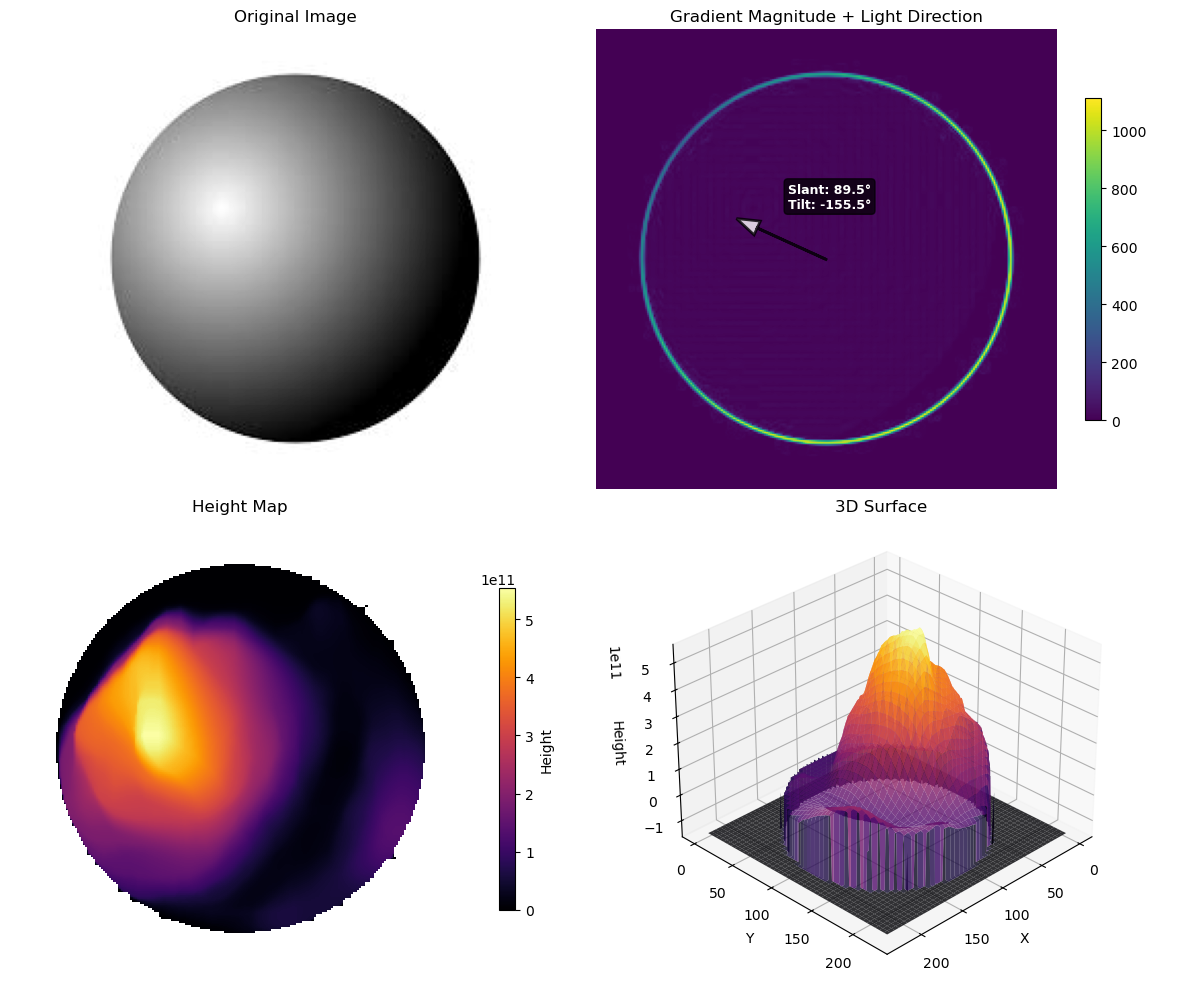

Finished


In [52]:
img_dir = "/home/lucie/Downloads/sphere.jpeg"

surface, slant, tilt = process_image(img_dir, visualize=True, export=False)

Code for iterating over the subdirs

In [53]:
base_dir = "/home/lucie/Dropbox/Goethe/datachallenges/DataChallenge2025_bueschelquinare"
sides = ["reverse"]
batches = ["G"]

for side in sides:
    for batch in batches:
        for img in os.listdir(base_dir + "/" + side + "/" + batch):
            
            img_dir = base_dir + "/" + side + "/" + batch + "/" + img
            
            surface, slant, tilt = process_image(img_dir, side, batch, visualize=True, tilt=np.radians(45.), slant=np.radians(65.))


Processing: /home/lucie/Dropbox/Goethe/datachallenges/DataChallenge2025_bueschelquinare/reverse/G/3962_r.jpg
Creating background mask...
Using provided - Slant: 65.0°, Tilt: 45.0°
Reconstructing surface...
Running SFS with slant=65.0°, tilt=45.0°


KeyboardInterrupt: 